### I'll be using my final refined model in deployment, so now I want to train it with the entire dataset.

In [10]:
# Import necessary libraries
import pandas as pd
import optuna
import numpy as np
from sklearn.metrics import recall_score, classification_report, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
pd.set_option('display.max_columns', 200) # Display all columns

In [11]:
df = pd.read_parquet("../data/processed/churn_prediction_dataset.parquet")
df.head()

,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_anual,mcomisiones,mactivos_margen,mpasivos_margen,cant_total_prod,tpaquete1,tpaquete2,tpaquete3,tpaquete4,tpaquete5,tpaquete6,tpaquete7,tpaquete8,tpaquete9,mdescubierto_preacordado,mcuentas_saldo,ctarjeta_debito_transacciones,mautoservicio,ctarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ctarjeta_master,ctarjeta_master_transacciones,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,cplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,cfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolares,ctitulos,mtitulos,cseguro_auto,cseguro_vivienda,cseguro_accidentes_personales,ccaja_seguridad,mbonos_corporativos,mmonedas_extranjeras,minversiones_otras,cplan_sueldo,mplan_sueldo,mplan_sueldo_manual,cplan_sueldo_transaccion,ccuenta_debitos_automaticos,mcuenta_debitos_automaticos,ctarjeta_visa_debitos_automaticos,mttarjeta_visa_debitos_automaticos,cpagodeservicios,mpagodeservicios,cpagomiscuentas,mpagomiscuentas,mcomisiones_mantenimiento,ccomisiones_otras,mcomisiones_otras,ccambio_monedas,ccambio_monedas_compra,mcambio_monedas_compra,ccambio_monedas_venta,mcambio_monedas_venta,ctransferencias_recibidas,mtransferencias_recibidas,ctransferencias_emitidas,mtransferencias_emitidas,cextraccion_autoservicio,mextraccion_autoservicio,ccheques_depositados,mcheques_depositados,ccheques_emitidos,mcheques_emitidos,ccheques_depositados_rechazados,mcheques_depositados_rechazados,ccheques_emitidos_rechazados,mcheques_emitidos_rechazados,thomebanking,chomebanking_transacciones,cautoservicio,cautoservicio_transacciones,tmovimientos_ultimos90dias,visa_marca_atraso,visa_mfinanciacion_limite,visa_msaldototal,visa_msaldopesos,visa_msaldodolares,visa_mconsumospesos,visa_mconsumosdolares,visa_mlimitecompra,visa_mpagado,visa_mpagospesos,visa_mpagosdolares,visa_mconsumototal,visa_cconsumos,visa_mpagominimo,clase_binaria,visa_tenure_days,tcuentas_2,visa_cuenta_estado_11.0,visa_cuenta_estado_12.0,visa_cuenta_estado_19.0,visa_cuenta_estado_0.0
0,0,1,44,72,3296.69,14455.27,579.66,910.65,1411.60,11,1,0,0,0,0,0,0,0,0,1.17,-460.04,2,2574.00,1,17,19451.75,1,18,17091.34,3,73704.79,0,0.0,0.0,0,0.0,0.0,0,0.00,0,1,0,0,0,0,0,1,56580.03,0.0,0,1,68.94,0,0.0,0,0.00,0,0.0,0.00,14,579.66,0,0,0.0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,116,0.0,63180.0,29994.31,32262.86,2830.47,14555.47,59.47,70200.0,0.0,-19632.60,0.00,14555.47,13.0,3837.6,0,4207.0,False,False,False,False,False
1,0,0,78,159,1032.18,10141.18,790.58,71.21,135.29,6,1,0,0,0,0,0,0,0,0,1.17,6301.72,0,0.00,1,1,174.33,1,0,0.00,0,0.00,0,0.0,0.0,0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0,0.00,0.0,0,0,0.00,0,0.0,0,0.00,0,0.0,833.97,4,790.58,0,0,0.0,0,0.0,0,0.0,1,351.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,1,0,0,17,0.0,63180.0,182.45,213.46,0.00,-11.55,4.22,70200.0,0.0,-2976.51,62.78,-11.55,2.0,35.1,0,6863.0,False,False,False,False,False
2,0,1,64,299,-52.34,4752.64,236.08,-422.18,175.66,7,1,0,0,0,0,0,0,0,0,1.17,45.63,0,0.00,1,8,11670.93,1,0,0.00,0,0.00,0,0.0,0.0,0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0,0.00,0.0,0,0,0.00,0,0.0,0,0.00,0,0.0,0.00,6,236.08,0,0,0.0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,0,0,0,10,0.0,176904.0,10367.71,12130.22,0.00,6788.67,0.00,196560.0,0.0,-12753.00,0.00,6788.67,4.0,1977.3,0,10318.0,False,False,False,False,False
3,0,1,48,282,485.91,10676.87,1280.47,-1275.18,596.07,8,1,0,0,0,0,0,0,0,0,1.17,5429.85,4,4103.69,1,9,9840.21,1,14,12383.23,0,0.00,0,0.0,0.0,0,0.0,0.0,3,10509.33,0,0,0,0,0,0,0,0,0.00,0.0,0,4,5303.31,0,0.0,0,0.00,2,2460.0,833.97,18,1280.47,0,0,0.0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,78,0,0,85,0.0,176904.0,6754.10,7433.72,468.57,2946.70,10.51,196560.0,0.0,-3685.76,0.00,2946.70,5.0,573.3,0,3582.0,False,False,False,False,False
4,0,1,45,171,5878.27,24298.75,64.38,22.11,4947.03,9,1,0,0,0,0,0,0,0,0,1.17,563006.87,10,4313.45,1,2,1496.03,1,0,0.00,0,0.00,1,351000.0,0.0,0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0,0.00,0.0,0,0,0.00,0,0.0,7,2171.89,1,339.

In [12]:
# Features and target
X = df.drop(columns=["clase_binaria"])
y = df["clase_binaria"]

Train and observe performance metrics to ensure the model is still behaving as expected

In [13]:
# Split dataset into training and testing sets (if not already split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

# Define the scale_pos_weight heuristic based on class imbalance
scale_pos_weight_heuristic = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the objective function for hyperparameter optimization
def objective(trial):
    # Define the hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", scale_pos_weight_heuristic / 2, scale_pos_weight_heuristic * 2),
    }

    # Create the model with the trial hyperparameters
    model = XGBClassifier(**params, random_state=12, use_label_encoder=False, eval_metric="logloss")
    
    # Cross-validation score with recall as the metric
    recall_scorer = make_scorer(recall_score, average="binary", pos_label=1)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=recall_scorer)
    return np.mean(cv_scores)

# Create and optimize the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
final_model = XGBClassifier(**best_params, random_state=12, use_label_encoder=False, eval_metric="logloss")

# Train the model on the entire dataset (both training and testing data)
final_model.fit(X, y)

# Evaluate the model on the test set
y_pred = final_model.predict(X_test)  # Get binary predictions
recall = recall_score(y_test, y_pred, pos_label=1)  # 'BAJA / 1' is the churn class
print("Recall on test set:", recall)

# Generate the classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))

# Calculate and print the ROC AUC score
y_pred_proba = final_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Calculate the ROC AUC score
print("ROC AUC on test set:", roc_auc)



[I 2024-11-25 18:42:28,942] A new study created in memory with name: no-name-4030a667-2373-4d18-8914-6c1a73fdb8ac
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "

Best hyperparameters: {'n_estimators': 146, 'max_depth': 4, 'learning_rate': 0.011876778146732107, 'subsample': 0.7088538857277786, 'colsample_bytree': 0.6627345807387007, 'gamma': 2.064099390470438, 'reg_alpha': 4.036928889894163, 'reg_lambda': 9.12276094106337, 'scale_pos_weight': 165.17791983570066}


/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall on test set: 0.9100817438692098

Classification Report:
               precision    recall  f1-score   support

    No Churn       1.00      0.81      0.90     33778
       Churn       0.05      0.91      0.10       367

    accuracy                           0.81     34145
   macro avg       0.52      0.86      0.50     34145
weighted avg       0.99      0.81      0.89     34145

ROC AUC on test set: 0.941350746168725


### Observe important features in final model

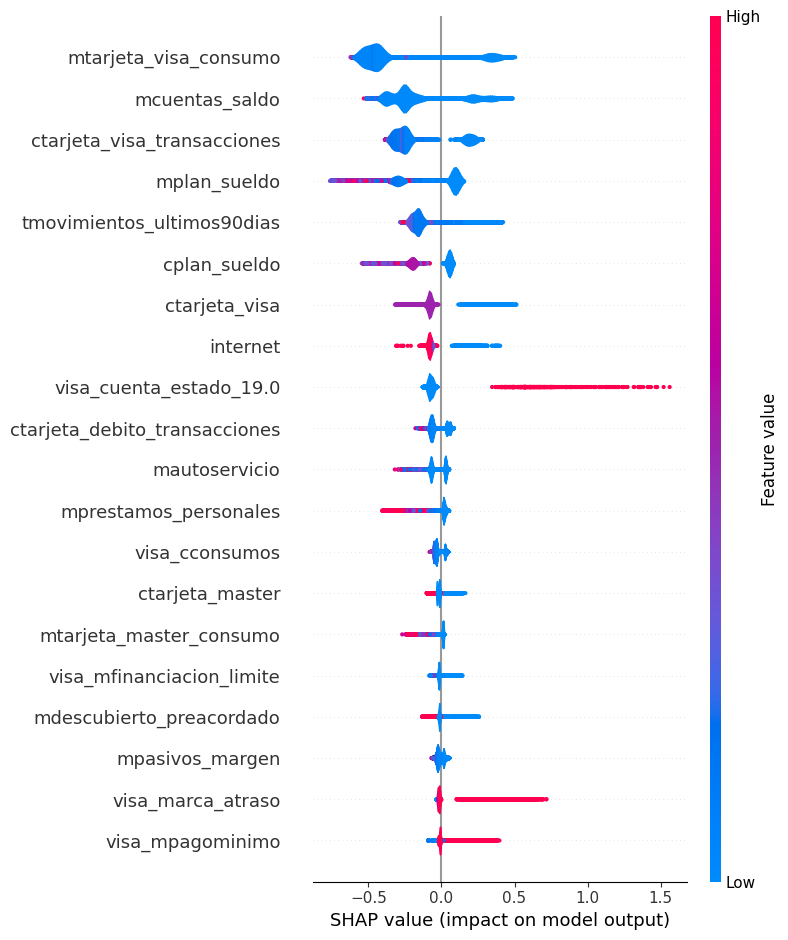

In [15]:
# Boolean columns (bool) need to be converted to integers for SHAP to process them:
X = X.astype({col: 'int64' for col in X.select_dtypes(include=['bool']).columns})

import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values
shap_values = explainer.shap_values(X)


# Plot the summary plot (violin-style)
shap.summary_plot(shap_values, X, plot_type="violin")

### Save the trained model to a file using pickle to load it for future use in deployment.

In [7]:
import pickle

# Save the trained model to the specified file path
model_path = "../models/final_model.pkl"
with open(model_path, "wb") as file:
    pickle.dump(final_model, file)

print(f"Model saved to '{model_path}'")


Model saved to '../models/final_model.pkl'


## In order to run the trained model over a new set of data, run ../scripts/predict_new_data.py with the updated path to the new data or follow these steps:

1. ### Load the new dataset.

        import pickle

        # Load the trained model from the file
        model_path = "../models/final_model.pkl"
        with open(model_path, "rb") as file:
            loaded_model = pickle.load(file)

        print("Model loaded successfully")
        
2. ### Preprocess the new data to match the format of the training data (e.g., same features, transformations, etc.).

        import sys
        sys.path.append("../src")  # Adjust path if necessary
        from preprocessing import preprocess_data

        new_data = pd.read_csv(".../data.csv", index_col=[0])

        new_data = preprocess_data(new_data)
        
3. ### Use the trained model to make predictions on the new data.
        
        X_new = new_data.drop(columns=["clase_binaria"])
        y_true = new_data["clase_binaria"]

        y_new_pred = loaded_model.predict(X_new)
        print("Predictions for the new data:", y_new_pred)

4. ### Evaluate the New Predictions.

        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

        # Calculate the accuracy of the model
        accuracy = accuracy_score(y_true, y_new_pred)
        print(f"Accuracy: {accuracy:.4f}")

        # Precision, Recall, F1 Score
        precision = precision_score(y_true, y_new_pred, pos_label=1)
        recall = recall_score(y_true, y_new_pred, pos_label=1)
        f1 = f1_score(y_true, y_new_pred, pos_label=1)

        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # ROC-AUC Score
        roc_auc = roc_auc_score(y_true, y_new_pred)
        print(f"ROC AUC: {roc_auc:.4f}")
